# Individual task. SARIMAX and Prophet
### Kirill Zakharov
2021

## **Sarimax**

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

In [12]:
#import file for colab research
from google.colab import files
uploaded = files.upload()

Saving 6_TGE_USA.csv to 6_TGE_USA.csv


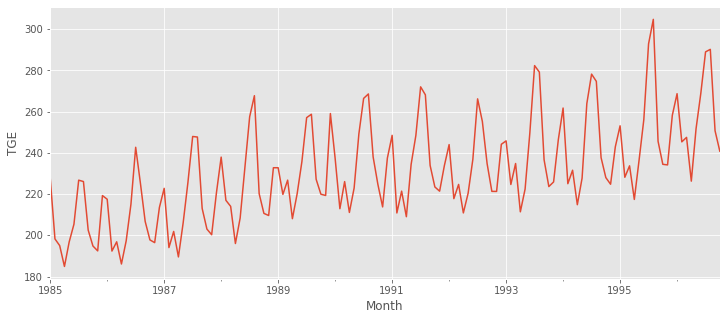

In [105]:
data = pd.read_csv('6_TGE_USA.csv', index_col='Month', parse_dates=True)
data.index = pd.DatetimeIndex(data.index, freq='MS')
data.columns = ['TGE']
data.head(4)

data['TGE'].plot(figsize=(12,5))
plt.ylabel('TGE')
plt.show()

Оптимальный параметр преобразования Бокса-Кокса: -0.977926
Критерий Дики-Фуллера: p=0.663682


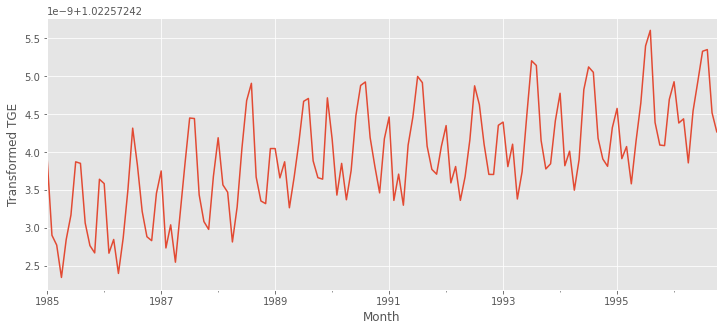

In [107]:
data['TGE'] = data['TGE']
data['TGE_box'], lmbda = boxcox(data['TGE'])
data['TGE_box'].plot(figsize=(12,5))
plt.ylabel('Transformed TGE')
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(data['TGE_box'])[1])

Критерий Дики-Фуллера: p=0.000000


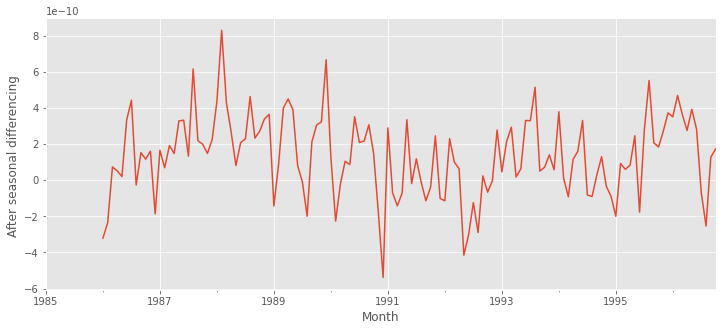

In [108]:
data['TGE_box_sdiff'] = data['TGE_box'].diff(12)
data['TGE_box_sdiff'].plot(figsize=(12,5))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(data['TGE_box_sdiff'].dropna())[1])

Критерий Дики-Фуллера: p=0.001150


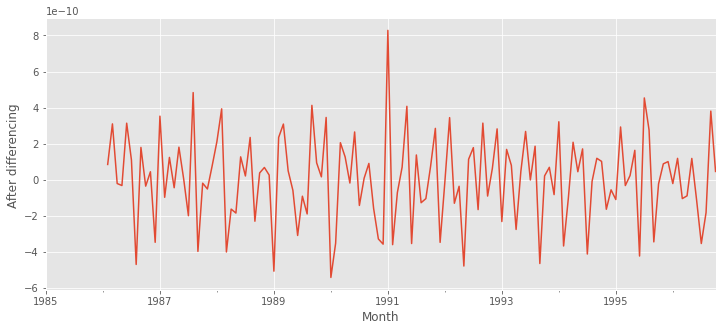

In [109]:
data['TGE_box_diff'] =  data['TGE_box_sdiff'].diff(1)
data['TGE_box_diff'].plot(figsize=(12,5))
plt.ylabel('After differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(data['TGE_box_diff'].dropna())[1])

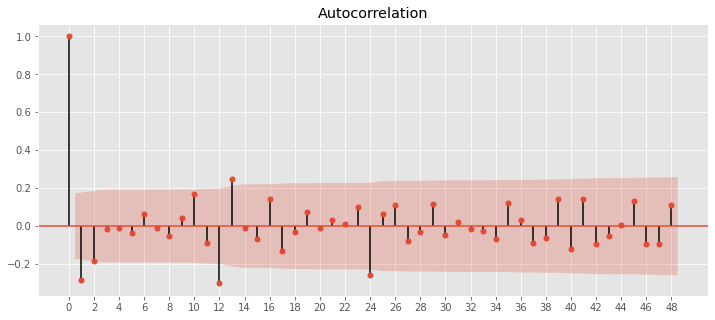

In [86]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(data['TGE_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Видно, что q = 2, Q = 2

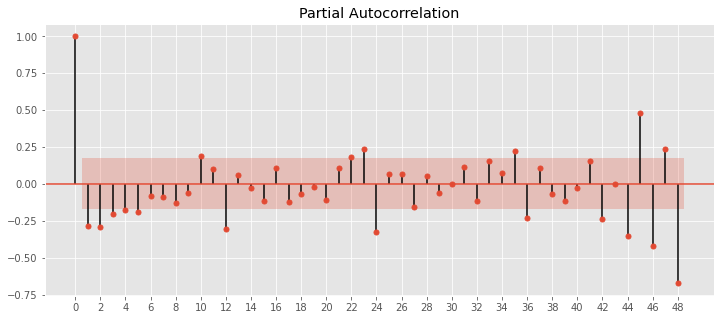

In [87]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(data['TGE_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

p = 5, P = 4

In [35]:
d=1
D=1
p = range(1, 6)
P = range(1, 5)
q = range(1, 3)
Q = range(1, 3)

In [36]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [38]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(data['TGE_box'],
                        order=(params[0], d, params[1]), 
                        seasonal_order=(params[2], D, params[3], 12), initialization='approximate_diffuse').fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dis

In [39]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters          aic
32  (3, 1, 1, 1) -2674.009333
64  (5, 1, 1, 1) -2533.536028
40  (3, 2, 1, 1) -2264.907753
56  (4, 2, 1, 1) -2234.534783
24  (2, 2, 1, 1) -2224.728733


In [110]:
test = SARIMAX(data['TGE_box'],
                        order=(2, d, 2), 
                        seasonal_order=(1, D, 1, 12), initialization='approximate_diffuse').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



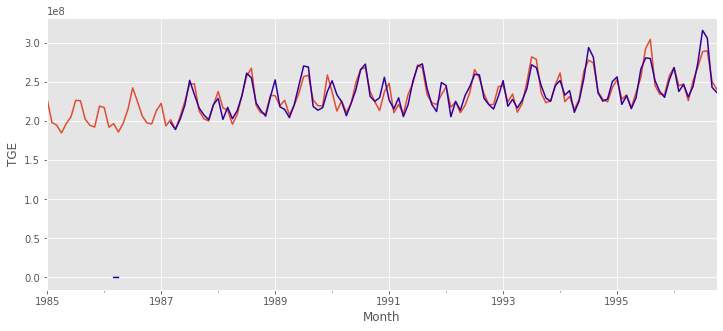

In [111]:
data['model'] = inv_boxcox(test.fittedvalues, lmbda)
data['TGE'].plot(figsize=(12,5))
data.model[13:].plot(color='#330099')
plt.ylabel('TGE')
plt.show()

In [112]:
start = data.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)

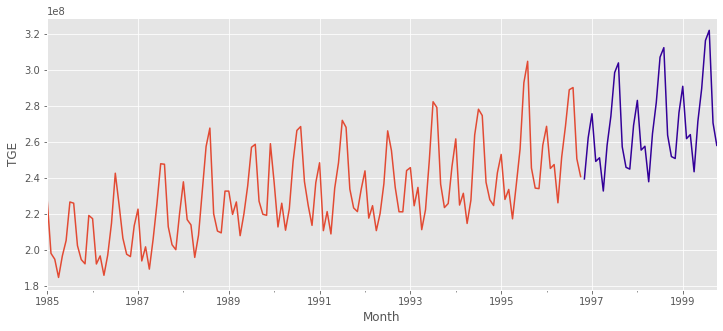

In [113]:
data['TGE'].plot(figsize=(12,5))
inv_boxcox(test.predict(start=start, end=end), lmbda).plot(color='#330099')
plt.ylabel('TGE')
plt.show()

## **Prophet**

In [114]:
data.head()

,TGE,TGE_box,TGE_box_sdiff,TGE_box_diff,model
Month,,,,,
1985-01-01,227860000.0,1.022572,NaN,NaN,1.000000
1985-02-01,198240000.0,1.022572,NaN,NaN,17.429935
1985-03-01,194970000.0,1.022572,NaN,NaN,NaN
1985-04-01,184880000.0,1.022572,NaN,NaN,82.810218
1985-05-01,196790000.0,1.022572,NaN,NaN,NaN


In [115]:
data_prophet = data[['TGE_box']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
data_prophet.head()

,ds,y
0,1985-01-01,1.022572
1,1985-02-01,1.022572
2,1985-03-01,1.022572
3,1985-04-01,1.022572
4,1985-05-01,1.022572


In [116]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(data_prophet)

In [117]:
future = model.make_future_dataframe(periods=36, freq='MS')

In [118]:
forecast = model.predict(future)

In [119]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
166,1998-11-01,1.022572,1.022568,1.022577
167,1998-12-01,1.022572,1.022568,1.022576
168,1999-01-01,1.022572,1.022568,1.022577
169,1999-02-01,1.022572,1.022568,1.022577
170,1999-03-01,1.022573,1.022568,1.022577
171,1999-04-01,1.022573,1.022568,1.022577
172,1999-05-01,1.022572,1.022568,1.022577
173,1999-06-01,1.022572,1.022568,1.022577
174,1999-07-01,1.022572,1.022568,1.022577
175,1999-08-01,1.022572,1.022567,1.022577


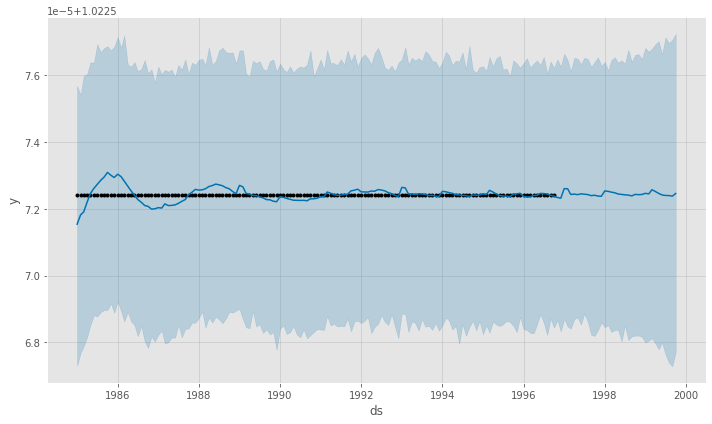

In [120]:
model.plot(forecast)
plt.show()

In [123]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.add_seasonality(name='monthly', period=12, fourier_order=10)
model.fit(data_prophet)

In [124]:
future = model.make_future_dataframe(periods=36, freq='MS')

In [125]:
forecast = model.predict(future)

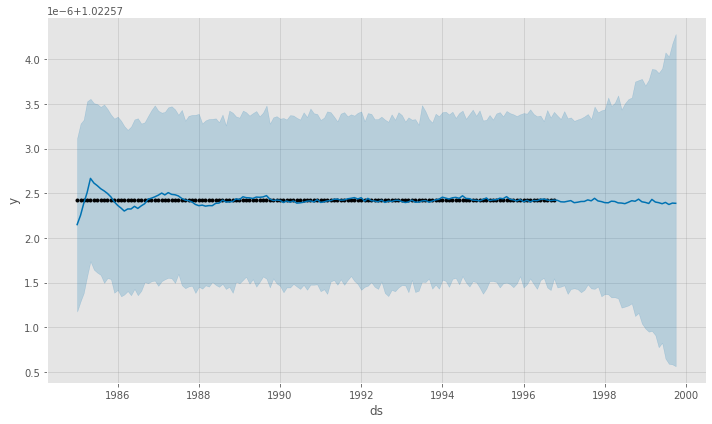

In [126]:
model.plot(forecast)
plt.show()